In [15]:
import pandas as pd
import plotly.graph_objs as go
import numpy as np

In [16]:
bitdata=pd.read_csv('Bitcoin_Data.csv') # Bitcoin data
altdata = pd.read_csv('Coins_Data_Master.csv') # All crypto data
# Cleaning the bitcoin data
bitdata.set_index("date",inplace=True)
bitdata.sort_values(by=["date"],inplace=True)

In [17]:
# Creating the moving averages
bitdata['10_sma']=bitdata["close"].rolling(10).mean()
bitdata['20_sma']=bitdata["close"].rolling(20).mean()

In [18]:
# Extracting the required columns
bit=bitdata[["close","10_sma","20_sma"]]

In [19]:
bit["signal"]=np.where(bit["10_sma"]>bit["20_sma"],1,0) # Creating signals
bit["signal"]=bit["signal"].diff() # Finding long or short trades
bitreturns=bit[bit["signal"].isin([1,-1])] # Extracting just the trades
bitreturns.reset_index(inplace=True)
trades = bitreturns[["signal","date"]] # Dataframe with trade signals and dates

/Users/joshthompkins/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/joshthompkins/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



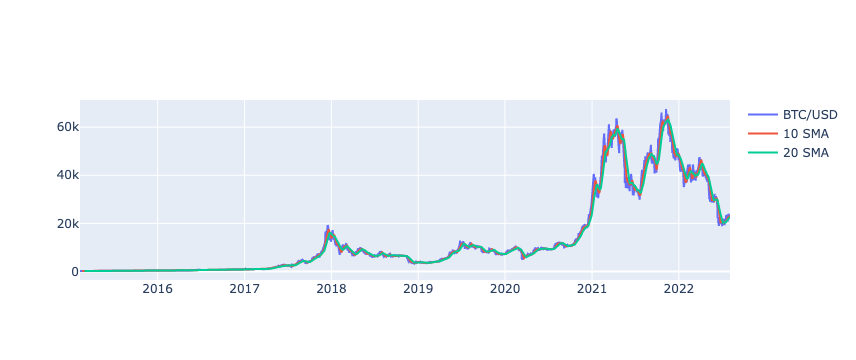

In [20]:
# Graph for BTC/USD
bitgraph = go.Figure(data=go.Scatter(x = bitdata.index, y = bitdata['close'],name='BTC/USD'))
bitgraph.add_scatter(x=bitdata.index,y=bitdata['10_sma'],name='10 SMA')
bitgraph.add_scatter(x=bitdata.index,y=bitdata['20_sma'],name='20 SMA')

In [21]:
alltrades=altdata.merge(trades,how="inner") # Adding the trade signals to the cryptos
symbols = alltrades["symbol"].unique()  # Dataframe with unique crypto symbols
total = pd.DataFrame(columns=['date', 'symbol', 'open', 'high', 'low', 'close', 'Volume USD','signal', 'buy', 'sell']) # Empty df for loop

In [22]:
# Loop to find buy and sell prices for each crypto according to the trading signal
for i in symbols:
    new=alltrades[alltrades["symbol"].isin([i])].sort_values("date")
    new["buy"]=np.select([new["signal"]==1,new["signal"]==-1],[(new["close"]),(new["close"].shift(-1))])
    new["sell"]=np.select([new["signal"]==1,new["signal"]==-1],[(new["close"].shift(-1)),(new["close"])])
    total = pd.concat([total,new])
# Dataframe with entry and exit prices for cryptos with signals generated from bitcoin smas
allreturns=total.sort_values("date").set_index(['date','symbol'])

In [23]:
allreturns.drop(columns=["open","high","low","close","Volume USD"], inplace=True)
allreturns

signal          buy    sell
date       symbol                               
2015-02-28 DASH/USD     1.0      0.00000    0.00
           LTC/USD      1.0      1.85200    1.75
           BTC/USD      1.0    255.77000  260.37
2015-03-21 LTC/USD     -1.0      1.46000    1.75
           DASH/USD    -1.0      0.00000    0.00
...                     ...          ...     ...
2022-07-12 ICE/USD      1.0      0.26544     NaN
           RBT/USD      1.0  19345.00000     NaN
           APE/USD      1.0      4.23120     NaN
           HMT/USD      1.0      0.19169     NaN
           STJ/USD      1.0      0.60805     NaN

[3253 rows x 3 columns]

In [24]:
allreturns.reset_index().set_index("symbol").sort_values("date").loc["XMR/USD"]

,date,signal,buy,sell
symbol,,,,
XMR/USD,2017-01-12,-1.0,11.80,12.03
XMR/USD,2017-01-24,1.0,11.80,17.77
XMR/USD,2017-03-14,-1.0,20.31,17.77
XMR/USD,2017-04-04,1.0,20.31,51.16
XMR/USD,2017-06-20,-1.0,45.83,51.16
...,...,...,...,...
XMR/USD,2022-05-31,1.0,198.35,198.63
XMR/USD,2022-06-01,-1.0,201.58,198.63
XMR/USD,2022-06-02,1.0,201.58,158.21


In [31]:
allreturns['profit']= allreturns['sell'] - allreturns['buy']

In [32]:
allreturns

signal          buy    sell  profit
date       symbol                                       
2015-02-28 DASH/USD     1.0      0.00000    0.00   0.000
           LTC/USD      1.0      1.85200    1.75  -0.102
           BTC/USD      1.0    255.77000  260.37   4.600
2015-03-21 LTC/USD     -1.0      1.46000    1.75   0.290
           DASH/USD    -1.0      0.00000    0.00   0.000
...                     ...          ...     ...     ...
2022-07-12 ICE/USD      1.0      0.26544     NaN     NaN
           RBT/USD      1.0  19345.00000     NaN     NaN
           APE/USD      1.0      4.23120     NaN     NaN
           HMT/USD      1.0      0.19169     NaN     NaN
           STJ/USD      1.0      0.60805     NaN     NaN

[3253 rows x 4 columns]

In [33]:
allreturns['profit_pct']= (allreturns['sell'] - allreturns['buy'])/allreturns['buy']

In [34]:
allreturns

signal          buy    sell  profit  profit_pct
date       symbol                                                   
2015-02-28 DASH/USD     1.0      0.00000    0.00   0.000         NaN
           LTC/USD      1.0      1.85200    1.75  -0.102   -0.055076
           BTC/USD      1.0    255.77000  260.37   4.600    0.017985
2015-03-21 LTC/USD     -1.0      1.46000    1.75   0.290    0.198630
           DASH/USD    -1.0      0.00000    0.00   0.000         NaN
...                     ...          ...     ...     ...         ...
2022-07-12 ICE/USD      1.0      0.26544     NaN     NaN         NaN
           RBT/USD      1.0  19345.00000     NaN     NaN         NaN
           APE/USD      1.0      4.23120     NaN     NaN         NaN
           HMT/USD      1.0      0.19169     NaN     NaN         NaN
           STJ/USD      1.0      0.60805     NaN     NaN         NaN

[3253 rows x 5 columns]

In [61]:
total = pd.DataFrame(columns = ['symbol','cumulative_return'])
for i in symbols:
    newd = allreturns.reset_index().set_index("symbol").sort_values("date").loc[i]
    new_row = {'symbol': i,'cumulative_return': newd['profit_pct'].cumprod().sum()}
    total = total.append(new_row, ignore_index = True)
total.sort_values(by='cumulative_return', ascending=False)

,symbol,cumulative_return
47,OMG/USD,7.318873
94,ETP/USD,1.823997
7,XRP/USD,0.643888
31,XVG/USD,0.526103
25,IDX/USD,0.454901
...,...,...
111,REP/USD,-0.468463
129,AID/USD,-0.483289
76,EOS/USD,-0.646055
45,BTT/USD,-20.641557


In [38]:
total

[-0.09063781038355219,
 -0.23969475404370794,
 -0.012633052331310013,
 -0.1458342405308676,
 -0.06612831995275825,
 -0.22830606306208112,
 -0.0025601115110120134,
 0.6438883461823282,
 -0.1287529693547425,
 -0.2215062189449579,
 -0.10409422623959037,
 -0.2352085611093651,
 -0.12493556166118937,
 0.3285823787316695,
 -0.13089009618122968,
 -0.1176036160235711,
 -0.05476296614408358,
 -0.2860617524301841,
 -0.11152833913284418,
 0.09075506111988751,
 -0.18004288556058387,
 -0.04016184960379811,
 0.15340816142546262,
 -0.11061089989288404,
 0.0656479395015661,
 0.4549009484591893,
 -0.03479699699839069,
 0.11772550738093743,
 -0.04497104784280798,
 0.005028746474700764,
 -0.06726680638662341,
 0.5261026776838795,
 -0.006069059255194659,
 -0.13139432318479285,
 -0.14640965578213183,
 -0.29938098983076283,
 -0.10085925099402979,
 -0.1565706995461649,
 -0.22817306515030125,
 -0.058794778700031705,
 0.0001716683379945508,
 -0.0854447092779702,
 0.37050680103494804,
 -0.14837361209998665,
 -0.